In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.streaming import StreamingContext
# Create a local StreamingContext with two working thread and batch interval of x seconds
spark=SparkSession.builder.appName("Twitter-streaming").master("local[2]").getOrCreate()
ssc = StreamingContext(spark.sparkContext, 100)
# Activate Checkpointing
ssc.checkpoint("checkpoint_TwitterApp")

In [2]:
host = "127.0.0.1"
port = 9995
tweets = ssc.socketTextStream(host, port)
lines = tweets.window(600)

In [3]:
def get_Sql_Context_Instance(sparkContext):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(sparkContext)
    return globals()['sqlContextSingletonInstance']

In [4]:
def aggregate_tags_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

def process(time, rdd):
    print("----------- %s -----------" % str(time))
    try:
        # Get spark sql singleton context from the current context
        sql_context = get_Sql_Context_Instance(rdd.context)
        
        # convert the RDD to Row RDD
        rows = rdd.map(lambda w: Row(word=w[0], word_count=w[1]))
        
        # create a DF from the Row RDD
        hashtags_df = sql_context.createDataFrame(rows)
        
        # Register the dataframe as table
        hashtags_df.registerTempTable("hashtags")
        
        # get the top 10 hashtags from the table using SQL and print them
        hashtag_counts_df = sql_context.sql("select word , word_count from hashtags where word like '#%'order by word_count desc limit 10")
        
        hashtag_counts_df.show()
        hashtag_counts_df.coalesce(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").csv("hashtag.csv")

    except Exception as e: 
        print(e)
        pass

In [5]:
# split each tweet into words
words = lines.flatMap(lambda line: line.split(" "))
              
# filter the words to get only hashtags, then map each hashtag to be a pair of (hashtag,1)
hashtags = words.map(lambda x: (x, 1)) 

# adding the count of each hashtag to its last count
tags_totals = hashtags.updateStateByKey(aggregate_tags_count)

# do processing for each RDD generated in each interval
tags_totals.foreachRDD(process)

In [6]:
ssc.start()

----------- 2022-01-01 14:32:30 -----------
+--------------+----------+
|          word|word_count|
+--------------+----------+
|    #Rajasthan|         1|
|#CoronaUpdate:|         1|
|        #COVID|         1|
|       #Jaipur|         1|
|       #Corona|         1|
|      #URGENTE|         1|
|        #Covid|         1|
|  #Welcome2022|         1|
| #HappyNewYear|         1|
|#COVID19France|         1|
+--------------+----------+

----------- 2022-01-01 14:33:00 -----------
+------------------+----------+
|              word|word_count|
+------------------+----------+
|          #NewYear|        38|
|            #COVID|         8|
|      #NewYear2022|         7|
|            #Covid|         6|
|#TigrayIsSuffering|         5|
|              #…RT|         5|
|          #newyear|         5|
|   #mytopfollowers|         5|
|        #Rajasthan|         4|
|    #CoronaUpdate:|         4|
+------------------+----------+

----------- 2022-01-01 14:33:30 -----------
+------------------+------

In [7]:
ssc.stop()

An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job 2 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:979)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:977)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:977)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2257)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2170)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:1988)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1357)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1988)
	at org.apache.spark.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('hashtag.csv')
df.describe()

FileNotFoundError: [Errno 2] No such file or directory: 'hashtag.csv'

----------- 2022-01-01 00:58:50 -----------


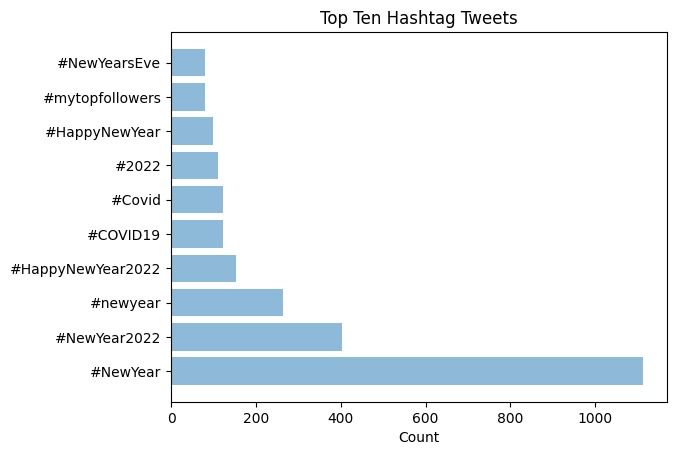

----------- 2022-01-01 00:59:00 -----------
----------- 2022-01-01 00:59:10 -----------
----------- 2022-01-01 00:59:20 -----------
----------- 2022-01-01 00:59:30 -----------
----------- 2022-01-01 00:59:40 -----------
----------- 2022-01-01 00:59:50 -----------
----------- 2022-01-01 01:00:00 -----------
----------- 2022-01-01 01:00:10 -----------
----------- 2022-01-01 01:00:20 -----------
----------- 2022-01-01 01:00:30 -----------
----------- 2022-01-01 01:00:40 -----------
----------- 2022-01-01 01:00:50 -----------
----------- 2022-01-01 01:01:00 -----------
----------- 2022-01-01 01:01:10 -----------
----------- 2022-01-01 01:01:20 -----------
----------- 2022-01-01 01:01:30 -----------
----------- 2022-01-01 01:01:40 -----------
----------- 2022-01-01 01:01:50 -----------


In [9]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = df.word
y_pos = np.arange(len(objects))
count = df.word_count
 
plt.barh(y_pos, count, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Count')
plt.title('Top Ten Hashtag Tweets')
 
plt.show()